# 情報リークの例
- 『Python機械学習プログラミング』のp.304のコラム

In [1]:
import numpy as np
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

# データの準備
- ランダムなデータセットをつくる
- ランダムなので、Xとyには関係性はない(=独立)
- ランダムなので、学習しても意味はないはず

In [2]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

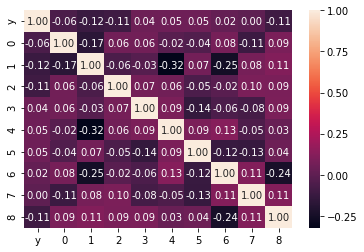

In [3]:
# ターゲットとの相関は全然ない
d1 = pd.DataFrame(y, columns=['y'])
d2 = pd.DataFrame(X)
d = pd.concat((d1, d2), axis=1)

corr = d.iloc[:, :10].corr()
sns.heatmap(corr,
            fmt='.2f',
            annot=True)

# 特徴量選択してやってみる

In [4]:
select = SelectPercentile(score_func=f_regression,
                          percentile=2)
select.fit(X, y)

X_select = select.transform(X)
print(X_select.shape)

(100, 200)


In [5]:
# test_score(決定係数)がかなり高い！！
cv_result = cross_validate(Ridge(), X_select, y, cv=5)

np.mean(cv_result['test_score'])

0.852832381095291

## 何が起こった？
- CVでの決定係数が0.905とかなり高い
- データは完全にランダムだから、これはおかしい！

## なんでこうなった？
- 特徴量選択の段階で、10,000個の中から、「たまたまターゲットに相関のある」特徴量が選択されたから
- 交差検証の外で、特徴量選択をしたので、訓練セットでも検証セットでもターゲットに相関のある特徴量が得られてしまったのだ。。。

0.35958172063297755

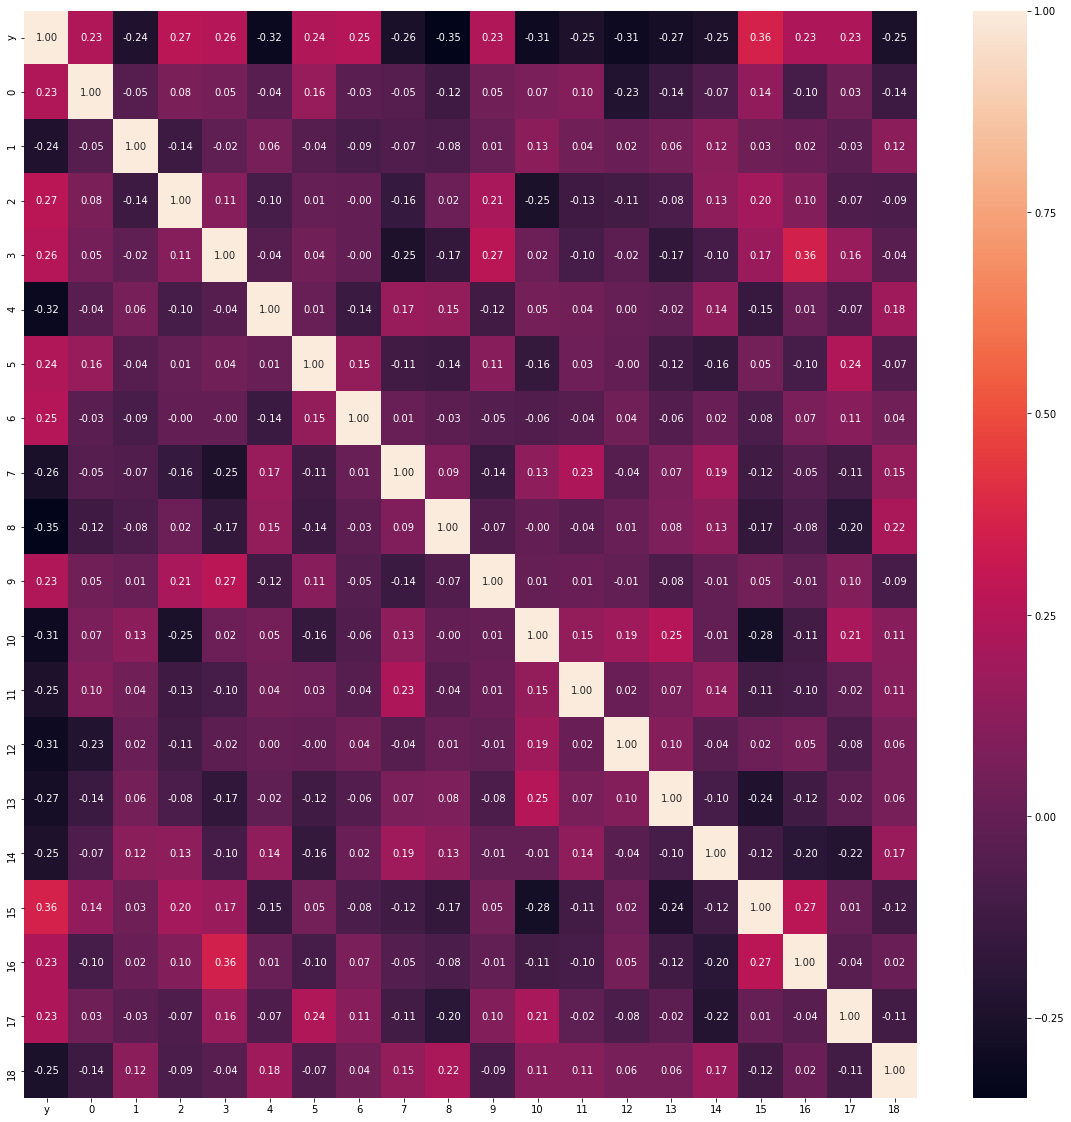

In [6]:
plt.rcParams['figure.figsize'] = 20,20

d1 = pd.DataFrame(y, columns=['y'])
d2 = pd.DataFrame(X_select)
d = pd.concat((d1, d2), axis=1)

corr = d.iloc[:, :20].corr()
sns.heatmap(corr,
            fmt='.2f',
            annot=True)

# ランダムだけど、「たまたま」相関が高いやつもでてきちゃう
corr['y'][1:].max()

# Pipelineを使った適切な処理順で検証

In [7]:
pipe = Pipeline([('select', SelectPercentile(score_func=f_regression, percentile=5)),
                 ('rigde', Ridge())])

cv_result_pipe = cross_validate(pipe, X, y, cv=5)
np.mean(cv_result_pipe['test_score'])

-0.24655422384952813

## 結果
- 決定係数が -0.25 と めっちゃ悪くなった
- もともとのランダムなデータなのだからこれは正しい！

## naze
- 今度は、R2スコアが負値となり、良くないモデルであることが示されている。
- パイプラインを使うことで特徴量抽出が交差検証ループの内側で行われている。
- このため、**特徴量抽出は、テスト用の部分は用いず**、訓練用の部分に対して行われるようになった。
- 特徴量抽出によって、**訓練セットのターゲットと相関がある特徴量が選択されるが**、データは完全にランダムなので、**選択された特徴量は、テストセットのターゲットとは相関がない。**
- この例では、特徴量選択過程でのデータのリークを修正することで、非常に良いと評価されたモデルが、実はまったく良くないモデルだと判明したことになる。